# Vanila GANs

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="1"

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


##  네트워크 정의


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)


file_name = 'ex_Vanila_GANs'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)

def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse) :
        
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,1024,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,128,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,64,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6

def simple_D(x,isTrain=True,reuse = False) :
    
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,28,28,1)


        conv1 = tf.layers.conv2d(x,64,[5,5], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,128,[5,5], strides=(1,1),padding = 'valid')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,256,[5,5], strides=(1,1),padding = 'valid')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

 
        conv4 = tf.layers.conv2d(r3,512,[4,4], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#512*8*8


        conv5 = tf.layers.conv2d(r4,1024,[4,4], strides=(2,2),padding = 'same')
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#1024*4*4

       
        conv6 = tf.layers.conv2d(r5,1,[4,4], strides=(1,1),padding = 'valid')
        r6 = tf.nn.sigmoid(conv6)#1*1*1


        return r6





Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


## 네트워크 구성

In [3]:
lr = 0.0002

z = tf.placeholder(tf.float32,shape=(None,1,1,100),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='u')

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 
    
G_z = simple_G(z,name='G_z')

D_real = simple_D(u,isTrain)
D_fake = simple_D(G_z,isTrain,reuse=True)

D_real_loss = tf.reduce_mean(-0.5*tf.log(D_real + 1e-8),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-0.5*tf.log(1 - D_fake + 1e-8),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-0.5*(tf.log(D_fake + 1e-8)),name='G_loss')
 

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]

    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :    
    D_optim = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_vars, name='G_optim')




## 학습

D_e : 0.885674, D_real_e : 0.466591, D_fake_e : 0.419083, G_e : 3.448189
D_e : 2.485562, D_real_e : 0.237977, D_fake_e : 2.263583, G_e : 6.517052
D_e : 2.039521, D_real_e : 0.231099, D_fake_e : 1.357921, G_e : 5.339668
D_e : 1.402479, D_real_e : 0.044119, D_fake_e : 0.077905, G_e : 4.803997
D_e : 1.070989, D_real_e : 0.036813, D_fake_e : 0.036390, G_e : 4.444325
D_e : 0.869442, D_real_e : 0.036102, D_fake_e : 0.025138, G_e : 4.269507
D_e : 0.730631, D_real_e : 0.019477, D_fake_e : 0.015709, G_e : 4.326920
D_e : 0.668727, D_real_e : 0.188480, D_fake_e : 0.108204, G_e : 4.027945
D_e : 0.606414, D_real_e : 0.088059, D_fake_e : 0.081545, G_e : 3.963819
D_e : 0.543104, D_real_e : 0.015846, D_fake_e : 0.020145, G_e : 3.883478
D_e : 0.502433, D_real_e : 0.066736, D_fake_e : 0.069252, G_e : 3.766342
D_e : 0.461982, D_real_e : 0.029056, D_fake_e : 0.028008, G_e : 3.700128
D_e : 0.427907, D_real_e : 0.026979, D_fake_e : 0.025757, G_e : 3.632344
D_e : 0.398535, D_real_e : 0.023836, D_fake_e : 0.0

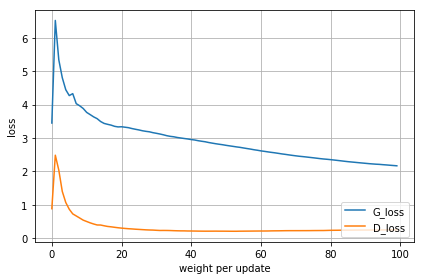

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,100))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for i in range(10000) :

        train_images,train_labels = mnist.train.next_batch(100)    
        u_ = np.reshape(train_images,(-1,28,28,1)) 
        z_ = np.random.normal(0,1,size=(100,1,1,100))


        _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True})
        D_error.append(D_e)
        D_real_error.append(D_real_e)
        D_fake_error.append(D_fake_e)


    #    train_images,train_labels = mnist.train.next_batch(100)    
    #    u_ = np.reshape(train_images,(-1,28,28,1)) 
    #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
        _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_, isTrain : True}) 
        G_error.append(G_e)
        
        if i%100 == 0:

            hist_D.append(np.mean(D_error)) 
            hist_G.append(np.mean(G_error))

            print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
                np.mean(D_fake_error), np.mean(G_error)))
            log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
                np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
            r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
            mnist_4by4_save(np.reshape(r,(-1,784)),file_name + '/result_{}.png'.format(str(i).zfill(3)))

            np.random.seed(int(time.time()))

            G_errer = []
            D_errer = []
            D_fake_error = []
            D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)